In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features

In [3]:
# freeze all VGG params
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [5]:
def load_image(img_path, max_size=400,shape=None):
    image = Image.open(img_path).convert("RGB")
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    
    # discard alpha channel and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [6]:
content = load_image('content.jpg').to(device)
style = load_image('style.jpg', shape=content.shape[-2:]).to(device)

In [7]:
# helper to display the image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

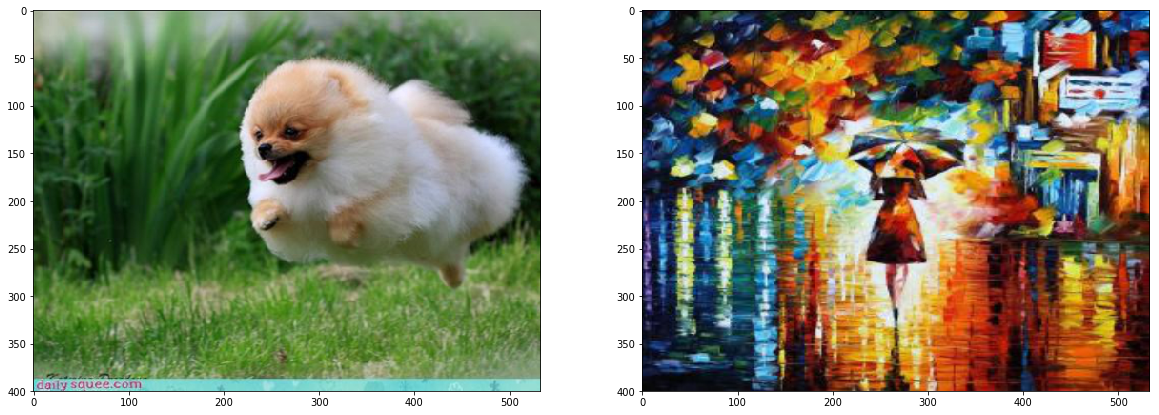

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 , 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# Get features

In [9]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', # content resp
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram Matrix

In [10]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Prepare Data

In [11]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [12]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features }

In [13]:
target = content.clone().requires_grad_(True).to(device)

# Loss, weights

In [14]:
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.8,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1 # alpha
style_weight = 1e6 # beta

# Iteration loop

ii:  400
Total loss:  4718076.5


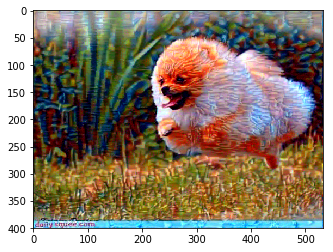

ii:  800
Total loss:  1084753.5


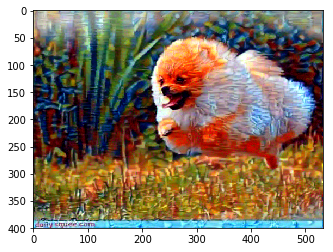

ii:  1200
Total loss:  573476.75


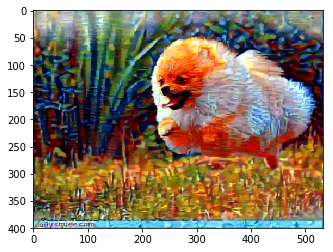

ii:  1600
Total loss:  374081.75


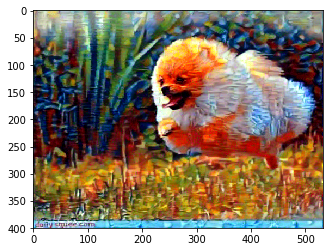

ii:  2000
Total loss:  272796.53125


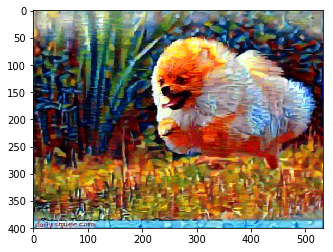

In [15]:
show_every = 400

optimizer = optim.Adam([target], lr=0.01)
steps = 2000  

for ii in range(1, steps + 1):
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h , w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update the image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print("ii: ", ii)
        print("Total loss: " , total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

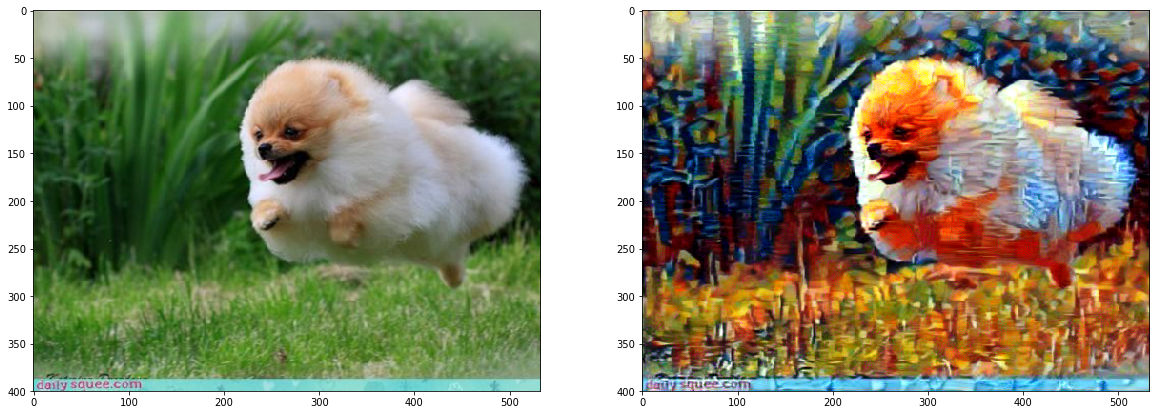

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 , 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))